[*********************100%***********************]  1 of 1 completed
<ipython-input-28-e95536ea345f>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454504  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465664  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362820  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351057  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393281  447610800
Train Data Shape: (2214, 1)
Test Data Shape: (554, 1)


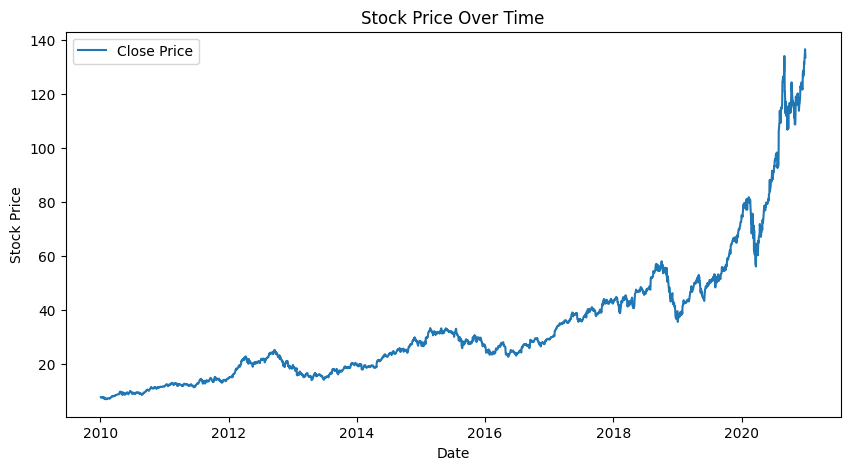

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0048
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 2.5813e-04
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.5964e-04
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 2.5590e-04
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 2.3480e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


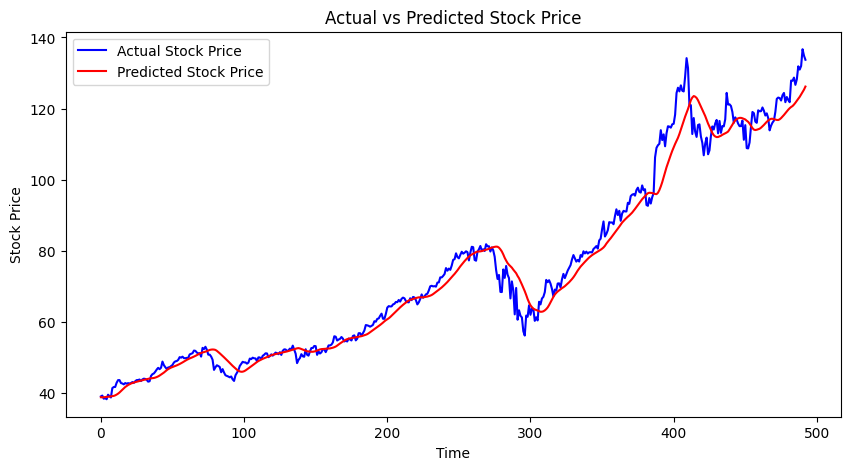

Value at Risk (VaR) at 95% confidence level: -0.026003011662966025


In [ ]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# 1. Data Collection
# Download stock data from Yahoo Finance
stock_data = yf.download('AAPL', start='2010-01-01', end='2020-12-31')
print(stock_data.head())  # Display the first few rows of the data

# 2. Data Preprocessing
# Handle missing data by filling them
stock_data.fillna(method='ffill', inplace=True)

# Normalize the 'Close' column for better performance of LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

# Split the data into 80% training and 20% testing
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Check the shapes of the datasets
print(f'Train Data Shape: {train_data.shape}')
print(f'Test Data Shape: {test_data.shape}')

# 3. Exploratory Data Analysis (EDA)
# Plot the stock price over time
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'], label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Daily return calculation
stock_data['Daily Return'] = stock_data['Close'].pct_change()

# 4. Building the LSTM Model
# Prepare the training dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set the time step
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next closing price
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Model Training & Evaluation
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Prepare test data
X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Make predictions using the test data
predictions = model.predict(X_test)

# 6. Predictions and Visualization
# Inverse transform the predictions to get actual prices
predictions = scaler.inverse_transform(predictions)

# Visualizing the results
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Close'].values[train_size + time_step + 1:], color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 7. Value at Risk (VaR) Calculation
# Calculate daily returns
daily_returns = stock_data['Daily Return'].dropna()

# Calculate VaR at 95% confidence level
VaR_95 = daily_returns.quantile(0.05)
print(f"Value at Risk (VaR) at 95% confidence level: {VaR_95}")
